## 画像コンペ

In [1]:
import numpy as np
np.random.seed(0)
import os

basepath = r"C:\DeepAnalytics\\"
img_files = os.listdir(basepath + r"train\train\\")

In [2]:
#訓練データの正解データ
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np
np.random.seed(0)
%matplotlib inline

train = pd.read_csv(basepath+"train_master.tsv", sep="\t")

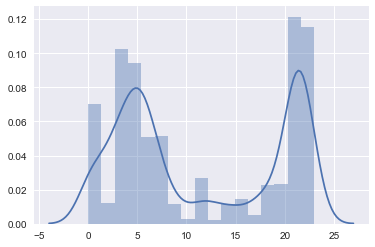

In [3]:
#histogram
sns.distplot(train["category_id"].values)

In [4]:
#utils
#画像のpixelを作成
def get_img_array(path,resize):
    img_array = Image.open(path).resize([resize,resize]).getdata()
    return img_array

#画像を表示
def show_img(path):
    img_array = Image.open(path).resize([128,128])
    img_array.show()

#pickle書き出し(<4GB)
import pickle
def write_pickle(pickle_path,v):
    with open(pickle_path, mode='wb') as f:
        pickle.dump(v, f)
    print("Finished Writing pickle")

#pickle 読み込み 
def read_pickle(pickle_path):
    with open(pickle_path, mode='rb') as f:
        read = pickle.load(f)
    return read

## データ準備(*)

In [5]:
import numpy as np

X = []
for i in train["file_name"]:
    X.append(np.hstack(get_img_array(basepath + r"train\train\\%s"%(i), 20)))

In [6]:
X = pd.DataFrame(X)

In [7]:
X.shape #(サンプル数, * *3)

(12399, 1200)

In [8]:
from sklearn.cross_validation import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X, train, test_size=0.5,random_state=0)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X_train.shape

(6199, 1200)

In [10]:
#X_train.to_csv(basepath+"X_train_true.csv")
#X_valid.to_csv(basepath+"X_valid_true.csv")
#y_train.to_csv(basepath+"y_train_true.csv")
#y_valid.to_csv(basepath+"y_valid_true.csv")


X_train = pd.read_csv(basepath+"X_train_true.csv")
X_valid = pd.read_csv(basepath+"X_valid_true.csv")
y_train = pd.read_csv(basepath+"y_train_true.csv")
y_valid = pd.read_csv(basepath+"y_valid_true.csv")

## CNN

In [11]:
def preprocessing_for_keras(X):
    X_n = X/255
    X_n.astype("float32")
    X_n = X_n.values.reshape(X.shape[0], 3, 20, 20)    
    return X_n

In [12]:
#X_train, X_validはcsvファイル経由だと一番左にゴミがある
X_train_keras = preprocessing_for_keras(X_train.iloc[:,1:])

In [13]:
X_valid_keras = preprocessing_for_keras(X_valid.iloc[:,1:])

In [14]:
import keras.backend as K
from keras.optimizers import Optimizer


class Eve(Optimizer):
    '''Eve optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1/beta_2/beta_3: floats, 0 < beta < 1. Generally close to 1.
        small_k/big_K: floats
        epsilon: float >= 0. Fuzz factor.
    # References
        - [Improving Stochastic Gradient Descent With FeedBack](http://arxiv.org/abs/1611.01505v1.pdf)
    '''

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 beta_3=0.999, small_k=0.1, big_K=10,
                 epsilon=1e-8, decay=0., **kwargs):
        super(Eve, self).__init__(**kwargs)
        self.__dict__.update(locals())
        self.iterations = K.variable(0)
        self.lr = K.variable(lr)
        self.beta_1 = K.variable(beta_1)
        self.beta_2 = K.variable(beta_2)
        self.beta_3 = K.variable(beta_3)
        self.small_k = K.variable(small_k)
        self.big_K = K.variable(big_K)
        self.decay = K.variable(decay)
        self.inital_decay = decay

    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.inital_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        f = K.variable(0)
        d = K.variable(1)
        self.weights = [self.iterations] + ms + vs + [f, d]

        cond = K.greater(t, K.variable(1))
        small_delta_t = K.switch(K.greater(loss, f), self.small_k + 1, 1. / (self.big_K + 1))
        big_delta_t = K.switch(K.greater(loss, f), self.big_K + 1, 1. / (self.small_k + 1))

        c_t = K.minimum(K.maximum(small_delta_t, loss / (f + self.epsilon)), big_delta_t)
        f_t = c_t * f
        r_t = K.abs(f_t - f) / (K.minimum(f_t, f))
        d_t = self.beta_3 * d + (1 - self.beta_3) * r_t

        f_t = K.switch(cond, f_t, loss)
        d_t = K.switch(cond, d_t, K.variable(1.))

        self.updates.append(K.update(f, f_t))
        self.updates.append(K.update(d, d_t))

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (d_t * K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))

            new_p = p_t
            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)
            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'beta_3': float(K.get_value(self.beta_3)),
                  'small_k': float(K.get_value(self.small_k)),
                  'big_K': float(K.get_value(self.big_K)),
                  'epsilon': self.epsilon}
        base_config = super(Eve, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [18]:
#CNN
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
import keras 
import h5py
# import tensorflow as tf  ※TensorFlowのみ 
# from keras.initializers import glorot_uniform

# tf.set_random_seed(0)  ※TensorFlowのみ

batch_size = 64
nb_classes = len(np.unique(y_train["category_id"]))
nb_epoch = 300
data_augmentation = True
input_shape = (3, 20, 20)

# input image dimensions
img_rows, img_cols = 20, 20
# the images are RGB
img_channels = 3

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train["category_id"].values, nb_classes)
Y_valid  = np_utils.to_categorical(y_valid["category_id"].values ,  nb_classes)
#Y_test  = np_utils.to_categorical(y_test.values ,  nb_classes)

#callbacks
#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')
sv_cb = keras.callbacks.ModelCheckpoint(basepath+"weight\\weights_epoch_{epoch:02d}-{val_loss:.2f}.hdf5", 
monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=input_shape, padding="same"))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25,seed=0))

model3.add(Flatten())
model3.add(Dense(100))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5,seed=0))
model3.add(Dense(nb_classes))
model3.add(Activation('softmax'))


# let's train the model using Eve.
eve = Eve()
model3.compile(loss='categorical_crossentropy',
              optimizer=eve,
              metrics=['accuracy'])

model3.summary()


history3 = model3.fit(X_train_keras[:100], Y_train[:100],
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(X_valid_keras[:100],  Y_valid[:100]),
          shuffle=True,
          callbacks=[sv_cb],
          )

X_train shape: (6199, 1201)
6199 train samples
6200 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 20, 20)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 20, 20)        80        
_________________________________________________________________
activation_9 (Activation)    (None, 32, 20, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 18, 18)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 18, 18)        72        
_________________________________________________________________
activation_10 (Activation)   (None, 32, 18, 18)        0         
_________________________________________________________________
max_pooling

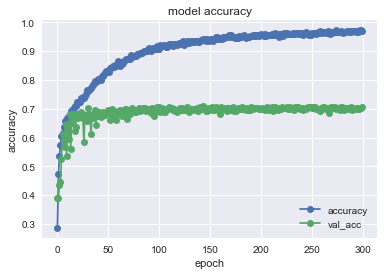

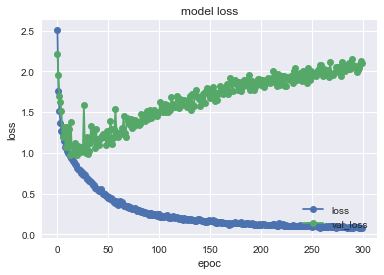

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history["acc"],"o-",label="accuracy")
    plt.plot(history.history["val_acc"],"o-",label="val_acc")
    plt.title("model accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="lower right")
    plt.show()

    plt.plot(history.history["loss"],"o-",label="loss",)
    plt.plot(history.history["val_loss"],"o-",label="val_loss")
    plt.title("model loss")
    plt.xlabel("epoc")
    plt.ylabel("loss")
    plt.legend(loc="lower right")
    plt.show()
# modelに学習させた時の変化の様子をplot
plot_history(history=history3)

## Evaluation

In [20]:
def get_jpg_name(path):
    import os 
    img_files = os.listdir(path)
    return [jpg for jpg in img_files if ".jpg" in jpg]

In [21]:
X_prediction_files  = get_jpg_name(basepath+r"test\test\\")    #予測するやつ
resize = 20

X_prediction_data = []
for i in range(len(X_prediction_files)):
    X_prediction_data.append(np.hstack(get_img_array(basepath + "test\\test\\test_%s.jpg"%(i), resize)))
X_prediction_data = pd.DataFrame(X_prediction_data)

In [22]:
X_prediction_files

['test_0.jpg',
 'test_1.jpg',
 'test_10.jpg',
 'test_100.jpg',
 'test_1000.jpg',
 'test_1001.jpg',
 'test_1002.jpg',
 'test_1003.jpg',
 'test_1004.jpg',
 'test_1005.jpg',
 'test_1006.jpg',
 'test_1007.jpg',
 'test_1008.jpg',
 'test_1009.jpg',
 'test_101.jpg',
 'test_1010.jpg',
 'test_1011.jpg',
 'test_1012.jpg',
 'test_1013.jpg',
 'test_1014.jpg',
 'test_1015.jpg',
 'test_1016.jpg',
 'test_1017.jpg',
 'test_1018.jpg',
 'test_1019.jpg',
 'test_102.jpg',
 'test_1020.jpg',
 'test_1021.jpg',
 'test_1022.jpg',
 'test_1023.jpg',
 'test_1024.jpg',
 'test_1025.jpg',
 'test_1026.jpg',
 'test_1027.jpg',
 'test_1028.jpg',
 'test_1029.jpg',
 'test_103.jpg',
 'test_1030.jpg',
 'test_1031.jpg',
 'test_1032.jpg',
 'test_1033.jpg',
 'test_1034.jpg',
 'test_1035.jpg',
 'test_1036.jpg',
 'test_1037.jpg',
 'test_1038.jpg',
 'test_1039.jpg',
 'test_104.jpg',
 'test_1040.jpg',
 'test_1041.jpg',
 'test_1042.jpg',
 'test_1043.jpg',
 'test_1044.jpg',
 'test_1045.jpg',
 'test_1046.jpg',
 'test_1047.jpg',
 'tes

In [23]:
def make_submission(path, pred_array,  X_prediction_files):
    #test_filesの順番がsample_submissionとは異なるため、変更する.
    submit_dic = {}
    for i in range(len(X_prediction_files)):
        submit_dic["test_%s.jpg"%(i)] = pred_array[i]

    submit_list = [] 
    for i in range(len(submit_dic)):
        submit_list.append(["test_%s.jpg"%(i),submit_dic["test_%s.jpg"%(i)]])    

    pd.DataFrame(submit_list).to_csv(path, index=None,columns=None)
    print("Finished Writing Submission file")

In [24]:
X_prediction_keras = preprocessing_for_keras(X_prediction_data)
pred_array = model3.predict_classes(X_prediction_keras)

make_submission(r"C:\DeepAnalytics\\sub_2.csv", pred_array = pred_array, X_prediction_files = X_prediction_files )

9792/9801 [============================>.] - ETA: 0sFinished Writing Submission file


In [25]:
#精度
def M_accuracy(true, pred):
    M_acc = {}
    for i in range(24):
        y_id = pred[true["category_id"].values==i] == i
        M_acc[i]=np.mean(y_id)
    return  np.mean([j for j in M_acc.values()]),M_acc

In [26]:
pred_valid = model3.predict_classes(X_valid_keras)

6200/6200 [==============================] - 21s    


In [27]:
acc,dic = M_accuracy(true=y_valid, pred=pred_valid)

In [28]:
len(np.unique(y_train["category_id"]))

24

In [29]:
dic

{0: 0.75088967971530252,
 1: 0.55704697986577179,
 2: 0.14705882352941177,
 3: 0.75401069518716579,
 4: 0.42715231788079472,
 5: 0.88556566970091022,
 6: 0.88782816229116945,
 7: 0.72590361445783136,
 8: 0.67741935483870963,
 9: 0.6767676767676768,
 10: 0.21739130434782608,
 11: 0.35135135135135137,
 12: 0.73333333333333328,
 13: 0.11764705882352941,
 14: 0.45454545454545453,
 15: 0.49090909090909091,
 16: 0.79661016949152541,
 17: 0.19148936170212766,
 18: 0.53260869565217395,
 19: 0.56862745098039214,
 20: 0.33333333333333331,
 21: 0.83448959365708619,
 22: 0.71261682242990654,
 23: 0.57763975155279501}

In [30]:
acc

0.55842648943102791